In [31]:
import cv2
import numpy as np
from matplotlib import pyplot
import tensorflow as tf

from tensorflow.python.client import device_lib

print("Show System RAM Memory:\n\n")
!cat /proc/meminfo | egrep "MemTotal*"
print("\n\nShow Devices:\n\n"+str(device_lib.list_local_devices()))

print("opencv :",cv2.__version__)
print("tensorflow :",tf.VERSION)

Show System RAM Memory:


MemTotal:        8041520 kB


Show Devices:

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17016947006835859412
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1225719808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8160744035889135824
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
opencv : 4.1.1
tensorflow : 1.9.0


In [32]:
# prepare generator model
from keras.models import load_model

g_model = load_model("epo10_step_400_G_GRAY2RGB-20191202-020608.h5")


In [34]:
# prepare resize color image
def prepare_resize_image(file_name):
    color_img = cv2.imread(file_name)
    resize_img = cv2.resize(color_img, desire_size)
#     gray_img = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)
    
#     cv2.imshow("color_img", color_img)
#     cv2.imshow("resize_img", resize_img)
#     cv2.imshow("gray_img", gray_img)
#     cv2.waitKey(0)
    return resize_img


# prepare dataset
# the input file must be an array of images
def prepare_real_samples(file):
    # load compressed arrays
    # data = load(filename)
    # load the face dataset
    # color_images = data['arr_0'].astype('uint8')
    color_images = file
    
    # print(type(src_images))
    gray_images = color_images.astype('uint8')
    gray_images [:,:,:,0] = color_images[:,:,:,0]/3 + color_images[:,:,:,1]/3 + color_images[:,:,:,2]/3
    gray_images [:,:,:,1] = gray_images [:,:,:,0]
    gray_images [:,:,:,2] = gray_images [:,:,:,0]
    
    # unpack arrays
    X1 = gray_images
    X2 = color_images

    # plot_images(color_images, 10)
    # plot_images(gray_images, 10)
    
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]



In [35]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from matplotlib.pyplot import figure
pyplot.rcParams['figure.figsize'] = [20, 10]


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y


def summarize_performance(save_path, step, g_model, dataset, n_samples = 1):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i][...,::-1])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i][...,::-1])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(n_samples, 3, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i][...,::-1])
        
    pyplot.show()
    # save plot to file
#     filename1 = save_path + 'plot_%03d.png' % (step+1)
#     pyplot.savefig(filename1)
#     pyplot.close()


In [36]:
# prepare input_names
import os

test_images_path = "test_images"
desire_size = (256,256)
files = []

# r=root, d=directories, f = files
for r, d, f in os.walk(test_images_path):
    for file in f:
        files.append(os.path.join(r, file))
    
for f in files:
    print(f)

test_images/visual-reverse-image-search-v2_intro.jpg
test_images/students-in-class-696x462.jpg
test_images/ocean.jpg
test_images/Screenshot-2019-02-18-at-10.56.29.png
test_images/Healthy-food-including-lean-meats-low-fat-milk-whole-grains-and-vegetables.jpg
test_images/Healthy Food Made Easy -min.jpg
test_images/960x0.jpg
test_images/tales-from-the-trenches.jpg
test_images/0.jpg


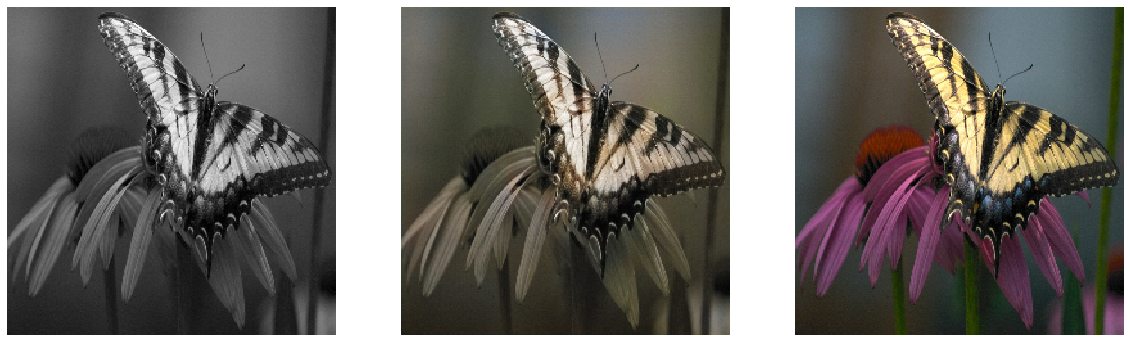

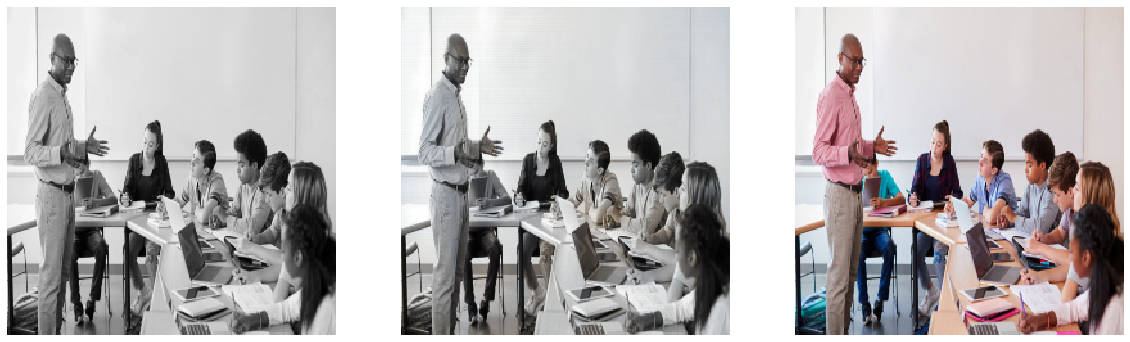

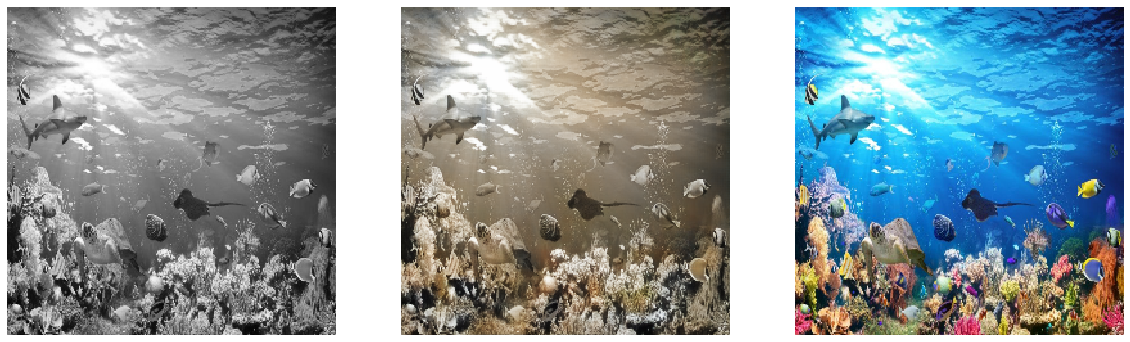

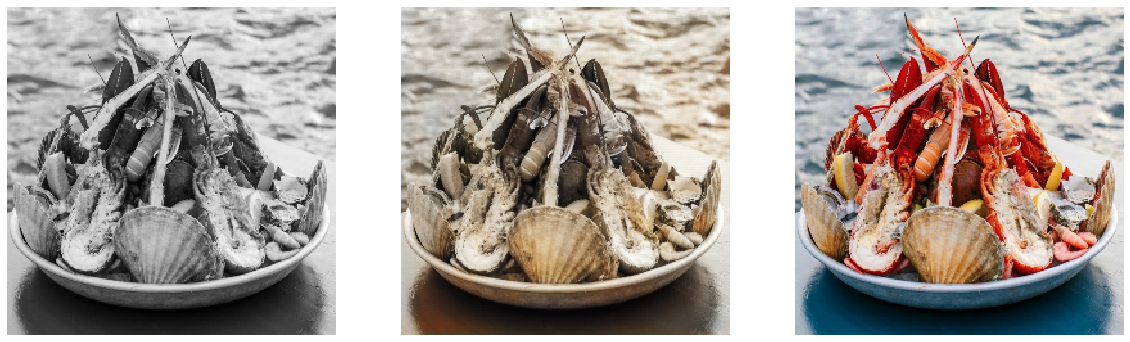

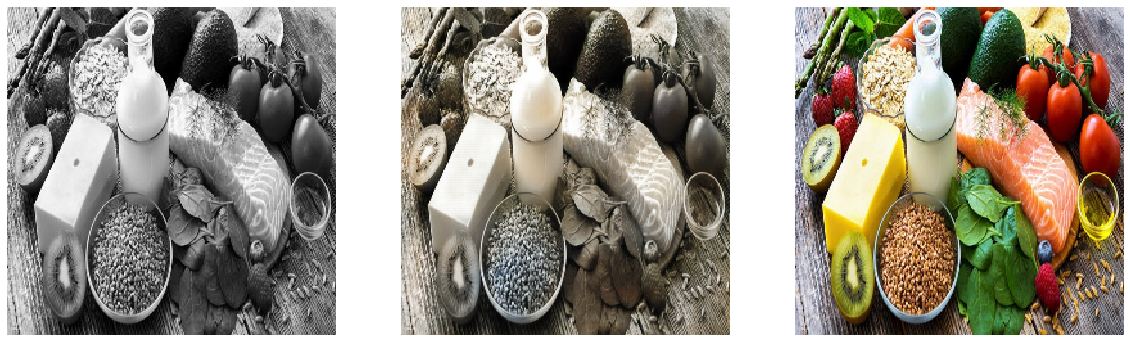

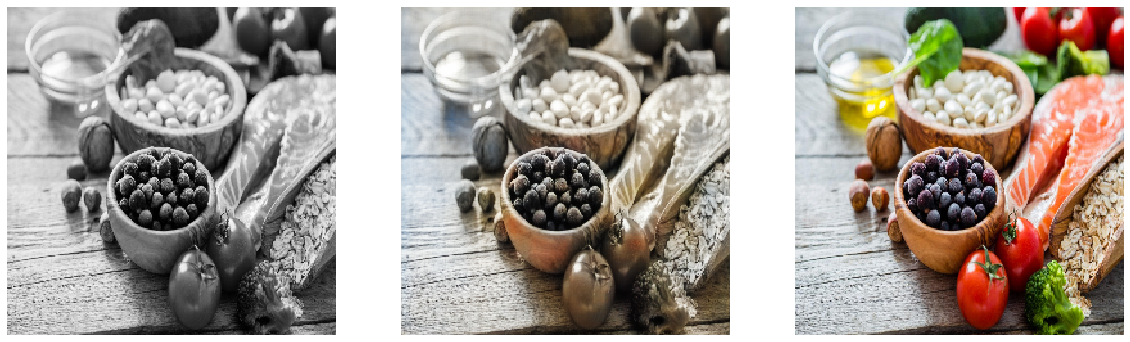

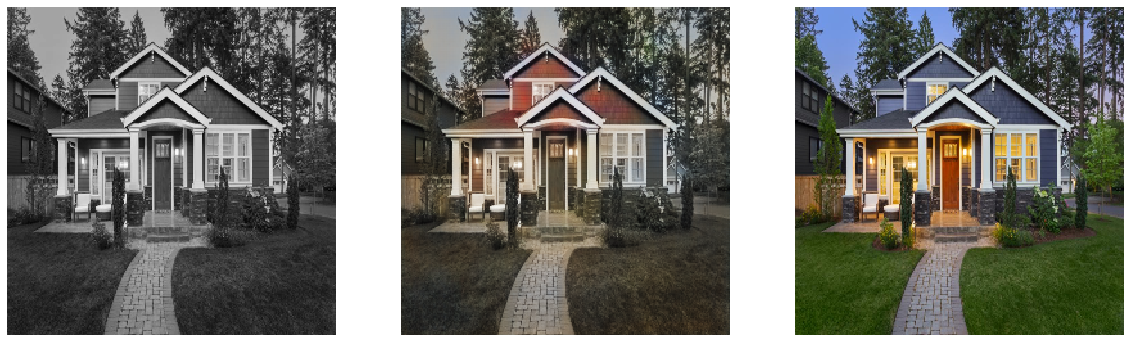

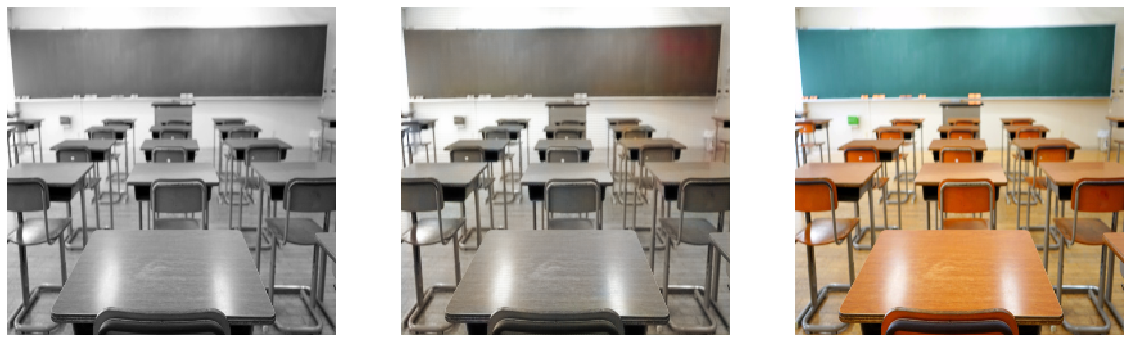

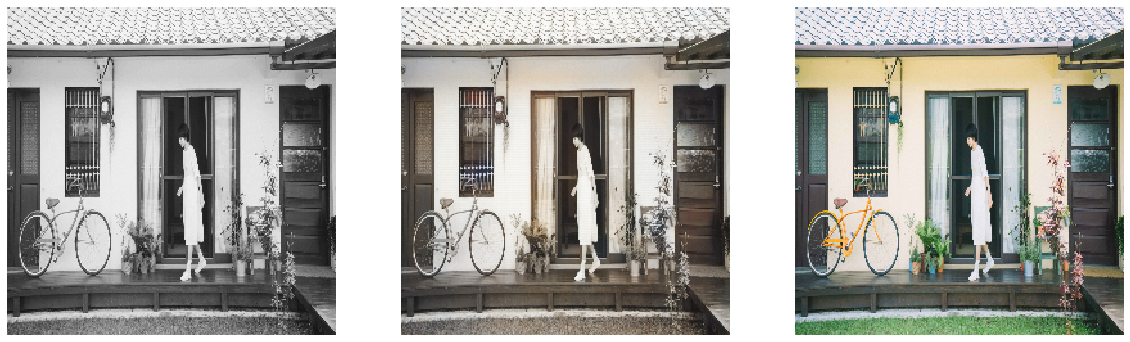

In [37]:
from numpy import asarray

for file in files:

    resize_img = prepare_resize_image(file)
    dataset = prepare_real_samples(asarray([resize_img])) # the input must be a list

    summery_path = ""
    step = 1
    summarize_performance(summery_path, step, g_model, dataset)
